In [247]:
#!pip install catboost
#!pip install lightgbm
#!pip install xgboost
#!pip install openpyxl
import numpy as np
import pandas as pd
import warnings
import datetime
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action="ignore")


df = pd.read_excel("veri.xlsx")

len(df.columns)

55

In [248]:
df["resesyonbagimlidegisken"].value_counts()
len(df[df["resesyonbagimlidegisken"].isin([1])]) / len(df["resesyonbagimlidegisken"])   

0.11394891944990176

# 1.VERİ SETİNİ İNCELEME - DEĞİŞKENLERİ TANIMLAMA - ARALARINDAKİ İLİŞKİYİ TESPİT ETME


In [177]:
################################################
# 1. Exploratory Data Analysis
################################################
## Dataframe hakkında bilgi
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(509, 55)
##################### Types #####################
date                                                                   datetime64[ns]
UOM-Consumerconfidence                                                        float64
UOM-currenteconomicconditions                                                 float64
UOM-consumerexpectations                                                      float64
UOM-inflationexpectations                                                     float64
stickycpi-yoy                                                                 float64
corecpi-yoy                                                                   float64
cpi                                                                           float64
cpi-yoy                                                                       float64
cpi-mom                                                                       float64
1ytreasury-fedfunds           

In [249]:
#DEĞİŞKEN TİPLERİNİ YAKALAMA

def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

cat_cols.remove("resesyonbagimlidegisken")       # bagimli degisken
num_cols.remove("date")                          #tarih.

Observations: 509
Variables: 55
cat_cols: 1
num_cols: 54
cat_but_car: 0
num_but_cat: 1


In [179]:
#Kategorik değişkenleri özetleme
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

        

#cat_summary(df,"gdplabel",plot=True)        #1 tanesinin özeti 
#hepsinin 
for col in cat_cols:
    cat_summary(df, col)


count   509.000
mean     86.402
std      12.549
min      51.700
5%       63.780
10%      67.500
20%      73.980
30%      80.340
40%      85.920
50%      89.900
60%      91.900
70%      93.900
80%      96.200
90%     100.020
95%     105.660
99%     108.668
max     111.400
Name: UOM-Consumerconfidence, dtype: float64


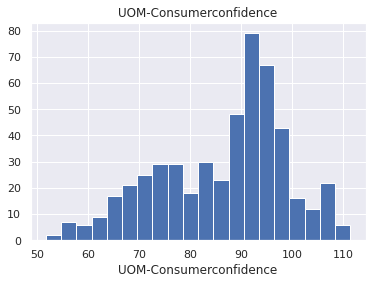

count   509.000
mean     97.894
std      13.701
min      57.500
5%       72.660
10%      76.580
20%      83.920
30%      92.480
40%      97.920
50%     102.300
60%     104.900
70%     106.800
80%     109.300
90%     113.220
95%     115.060
99%     117.760
max     121.200
Name: UOM-currenteconomicconditions, dtype: float64


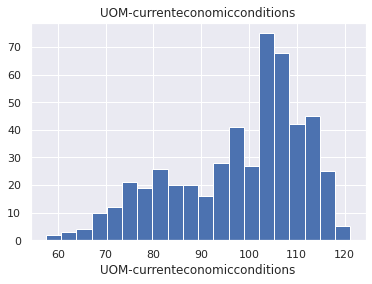

count   509.000
mean     79.020
std      12.583
min      44.300
5%       56.060
10%      62.000
20%      67.900
30%      71.680
40%      77.600
50%      80.900
60%      83.980
70%      86.460
80%      88.800
90%      93.240
95%     100.060
99%     104.184
max     108.600
Name: UOM-consumerexpectations, dtype: float64


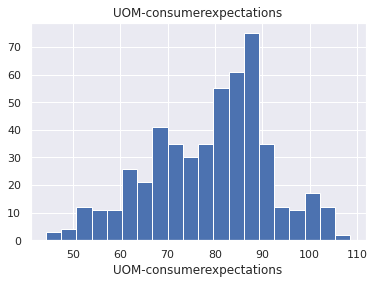

count   509.000
mean      3.356
std       1.307
min       0.400
5%        2.400
10%       2.500
20%       2.700
30%       2.800
40%       2.900
50%       3.000
60%       3.100
70%       3.300
80%       3.500
90%       4.600
95%       5.360
99%       9.600
max      10.400
Name: UOM-inflationexpectations, dtype: float64


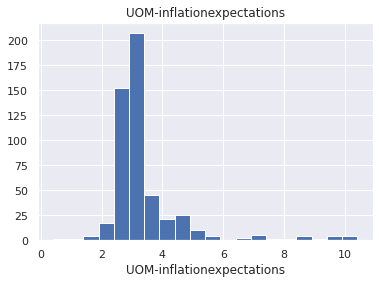

count   509.000
mean      3.577
std       2.293
min       0.736
5%        1.764
10%       2.040
20%       2.221
30%       2.430
40%       2.623
50%       2.876
60%       3.170
70%       3.543
80%       4.637
90%       5.156
95%       9.006
99%      13.288
max      15.171
Name: stickycpi-yoy, dtype: float64


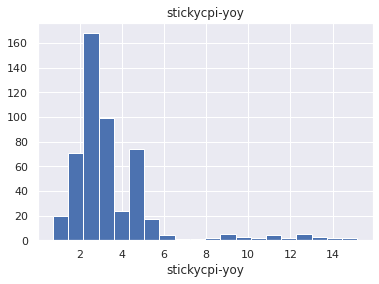

count   509.000
mean      3.321
std       2.285
min       0.600
5%        1.400
10%       1.700
20%       1.900
30%       2.100
40%       2.300
50%       2.500
60%       2.880
70%       3.800
80%       4.400
90%       5.100
95%       9.020
99%      12.292
max      13.600
Name: corecpi-yoy, dtype: float64


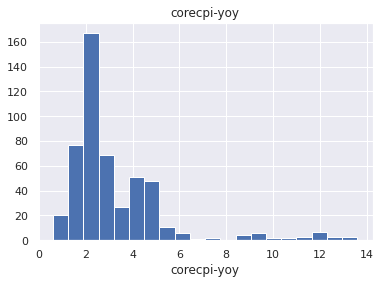

count   509.000
mean    176.861
std      54.414
min      78.000
5%       94.700
10%     103.220
20%     118.300
30%     141.340
40%     159.160
50%     176.100
60%     193.700
70%     217.262
80%     234.348
90%     249.467
95%     258.224
99%     279.998
max     288.663
Name: cpi, dtype: float64


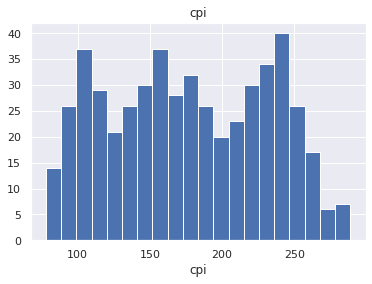

count   509.000
mean      3.263
std       2.493
min      -1.959
5%        0.683
10%       1.224
20%       1.684
30%       2.029
40%       2.452
50%       2.798
60%       3.120
70%       3.596
80%       4.269
90%       5.283
95%       8.244
99%      13.811
max      14.592
Name: cpi-yoy, dtype: float64


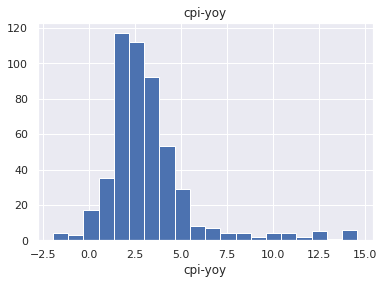

count   509.000
mean      0.261
std       0.300
min      -1.771
5%       -0.123
10%      -0.003
20%       0.073
30%       0.161
40%       0.194
50%       0.242
60%       0.289
70%       0.347
80%       0.423
90%       0.582
95%       0.793
99%       1.144
max       1.430
Name: cpi-mom, dtype: float64


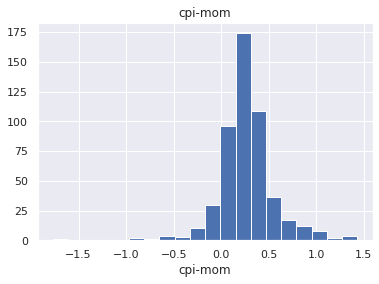

count   509.000
mean      0.043
std       0.643
min      -4.776
5%       -0.952
10%      -0.504
20%      -0.217
30%      -0.020
40%       0.036
50%       0.100
60%       0.172
70%       0.278
80%       0.400
90%       0.580
95%       0.826
99%       1.311
max       1.627
Name: 1ytreasury-fedfunds, dtype: float64


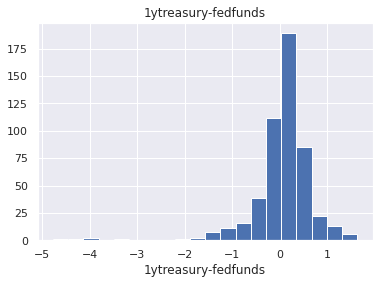

count   509.000
mean      4.470
std       3.829
min       0.051
5%        0.117
10%       0.179
20%       0.509
30%       1.508
40%       2.551
50%       4.176
60%       5.299
70%       5.948
80%       7.601
90%       9.368
95%      12.073
99%      15.341
max      16.719
Name: 1ytreasury, dtype: float64


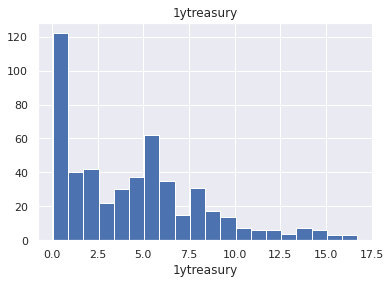

count   509.000
mean      0.980
std       0.882
min      -2.136
5%       -0.284
10%      -0.028
20%       0.191
30%       0.435
40%       0.642
50%       0.921
60%       1.143
70%       1.463
80%       1.847
90%       2.254
95%       2.476
99%       2.765
max       2.834
Name: 2-10yspread, dtype: float64


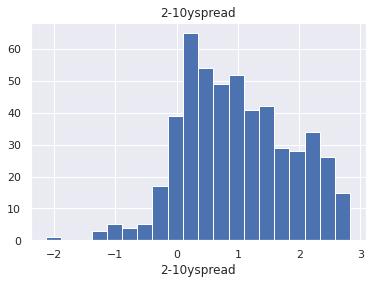

count   509.000
mean      4.785
std       3.833
min       0.115
5%        0.256
10%       0.398
20%       0.881
30%       1.753
40%       2.887
50%       4.417
60%       5.558
70%       6.290
80%       7.914
90%      10.169
95%      12.489
99%      14.880
max      16.458
Name: 2ytreasury, dtype: float64


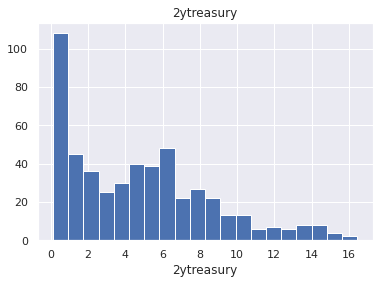

count   509.000
mean     -0.410
std       0.612
min      -4.410
5%       -1.372
10%      -1.062
20%      -0.718
30%      -0.480
40%      -0.328
50%      -0.200
60%      -0.100
70%      -0.060
80%      -0.030
90%       0.020
95%       0.080
99%       0.227
max       0.430
Name: 3mo-fedfunds, dtype: float64


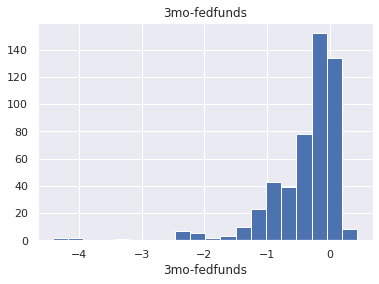

count   509.000
mean      5.311
std       3.627
min       0.267
5%        0.821
10%       1.252
20%       1.769
30%       2.611
40%       3.768
50%       4.822
60%       5.859
70%       6.757
80%       8.273
90%      10.807
95%      12.736
99%      14.618
max      15.930
Name: 5ytreasury, dtype: float64


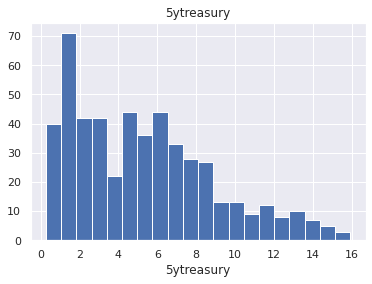

count   509.000
mean      1.338
std       1.506
min      -6.292
5%       -0.819
10%      -0.427
20%       0.216
30%       0.716
40%       1.161
50%       1.480
60%       1.862
70%       2.208
80%       2.634
90%       3.127
95%       3.352
99%       3.635
max       3.804
Name: 10y-fedfunds, dtype: float64


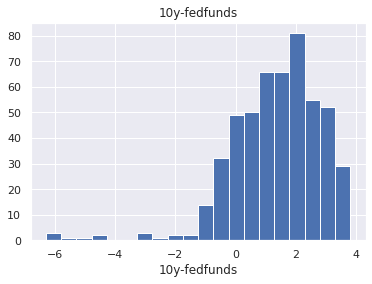

count   509.000
mean      4.416
std       4.066
min       0.050
5%        0.084
10%       0.100
20%       0.190
30%       1.254
40%       2.392
50%       4.030
60%       5.250
70%       5.850
80%       7.618
90%       9.434
95%      12.078
99%      17.803
max      19.100
Name: fedfunds, dtype: float64


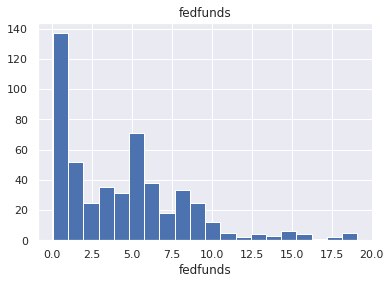

count   509.000
mean      5.765
std       3.395
min       0.624
5%        1.624
10%       1.933
20%       2.538
30%       3.434
40%       4.283
50%       5.110
60%       6.052
70%       7.224
80%       8.476
90%      10.946
95%      12.664
99%      14.298
max      15.324
Name: us10y, dtype: float64


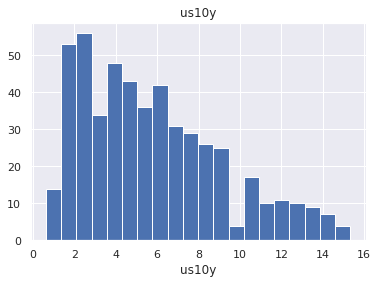

count   509.000
mean     94.499
std      25.133
min      25.300
5%       52.900
10%      58.480
20%      68.460
30%      81.740
40%      91.020
50%      97.400
60%     102.600
70%     107.420
80%     116.420
90%     128.120
95%     135.420
99%     140.800
max     144.700
Name: confboard-consumerconf, dtype: float64


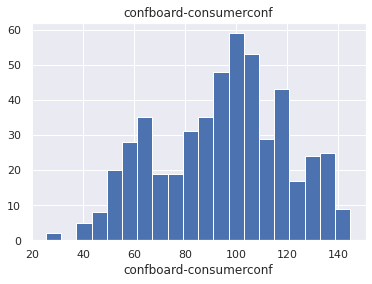

count   509.000
mean     81.929
std      19.006
min      46.100
5%       49.540
10%      55.640
20%      62.960
30%      67.040
40%      77.960
50%      84.200
60%      87.980
70%      92.600
80%     100.140
90%     106.520
95%     112.460
99%     118.784
max     119.500
Name: confboard-leading10indicators, dtype: float64


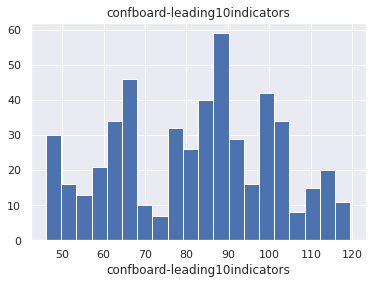

count   509.000
mean     91.005
std      16.180
min      27.300
5%       61.820
10%      70.480
20%      78.560
30%      84.880
40%      89.200
50%      92.900
60%      96.300
70%     100.300
80%     104.240
90%     109.320
95%     114.200
99%     119.484
max     124.300
Name: confboard-consumerconfexp, dtype: float64


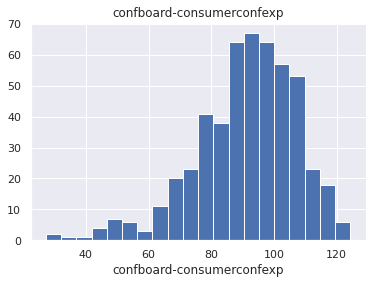

count   509.000
mean     99.741
std      46.084
min      15.800
5%       25.080
10%      32.940
20%      50.880
30%      71.580
40%      90.520
50%     101.300
60%     114.680
70%     126.140
80%     142.160
90%     167.180
95%     173.260
99%     181.668
max     186.800
Name: confboard-consconf-present, dtype: float64


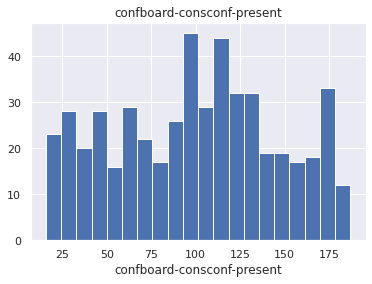

count   509.000
mean     78.552
std      18.506
min      47.400
5%       48.580
10%      51.940
20%      59.760
30%      62.700
40%      72.680
50%      84.200
60%      86.780
70%      91.860
80%      95.140
90%     102.580
95%     105.600
99%     107.392
max     108.800
Name: confboard-coincident composite, dtype: float64


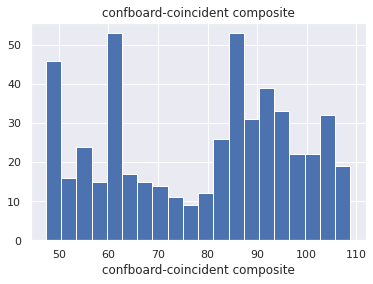

count      509.000
mean    125882.532
std      18515.600
min      82255.000
5%       91247.800
10%     100598.000
20%     109385.800
30%     115160.200
40%     123282.200
50%     128803.000
60%     132215.000
70%     135336.400
80%     144875.000
90%     149621.600
95%     151963.000
99%     154512.440
max     158103.000
Name: confboard-leadingman-neworder, dtype: float64


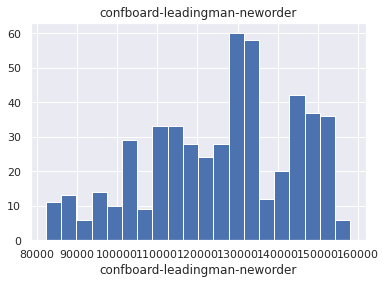

count   509.000
mean     52.163
std       5.786
min      29.400
5%       39.940
10%      45.260
20%      48.500
30%      50.100
40%      51.300
50%      52.700
60%      53.980
70%      55.500
80%      56.700
90%      58.800
95%      60.460
99%      63.052
max      69.900
Name: ISM-businessconf, dtype: float64


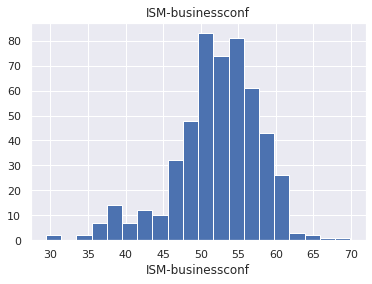

count   509.000
mean     54.881
std       7.613
min      24.200
5%       40.400
10%      45.760
20%      49.500
30%      51.800
40%      53.720
50%      55.400
60%      57.600
70%      59.400
80%      61.100
90%      63.620
95%      64.960
99%      69.192
max      74.800
Name: ISM-man-neworders, dtype: float64


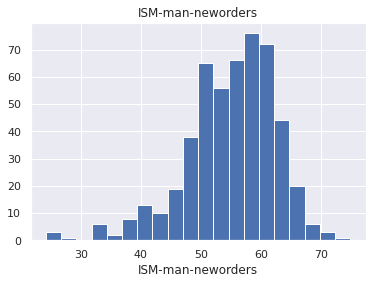

count   509.000
mean     48.752
std       6.529
min      27.800
5%       35.380
10%      40.920
20%      44.560
30%      46.200
40%      47.400
50%      49.600
60%      51.200
70%      52.800
80%      53.900
90%      56.220
95%      57.960
99%      60.384
max      62.300
Name: ISM-man-employment, dtype: float64


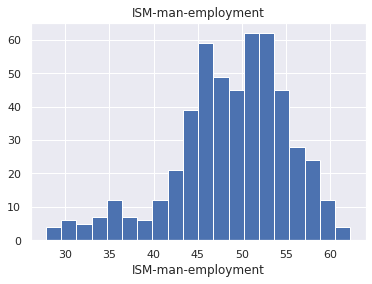

count   509.000
mean     54.696
std       8.337
min      20.700
5%       37.740
10%      43.860
20%      49.100
30%      51.300
40%      53.320
50%      55.400
60%      57.400
70%      59.300
80%      61.600
90%      64.540
95%      66.600
99%      70.644
max      75.200
Name: chicago-pmi, dtype: float64


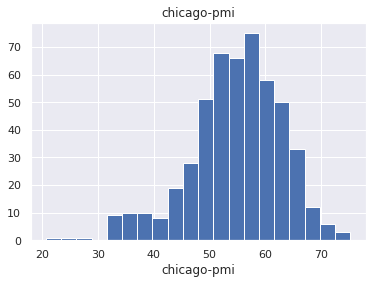

count   509.000
mean     -0.147
std       0.871
min      -1.049
5%       -0.784
10%      -0.736
20%      -0.668
30%      -0.608
40%      -0.529
50%      -0.440
60%      -0.338
70%      -0.171
80%       0.073
90%       0.715
95%       2.189
99%       3.186
max       3.851
Name: chicagoFC-av, dtype: float64


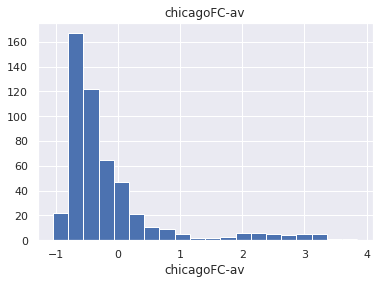

count   509.000
mean      8.480
std      17.525
min     -57.100
5%      -22.000
10%     -15.460
20%      -3.200
30%       2.740
40%       6.820
50%      10.500
60%      14.080
70%      17.800
80%      21.700
90%      27.720
95%      32.260
99%      42.236
max      50.200
Name: CURRENT ACTIVITY INDEX, dtype: float64


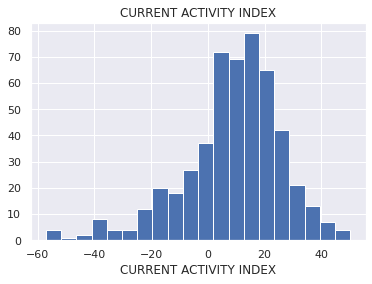

count   509.000
mean      9.492
std      15.730
min     -70.900
5%      -19.980
10%      -9.800
20%      -1.080
30%       3.780
40%       8.020
50%      11.300
60%      14.700
70%      17.460
80%      21.900
90%      27.540
95%      31.360
99%      38.176
max      47.400
Name: CURRENT NEW ORDERS, dtype: float64


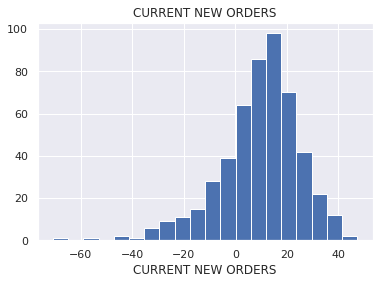

count   509.000
mean     -5.906
std      10.933
min     -51.000
5%      -24.160
10%     -19.600
20%     -14.600
30%     -11.100
40%      -8.300
50%      -5.100
60%      -2.800
70%      -0.340
80%       2.980
90%       7.660
95%      11.960
99%      18.084
max      25.600
Name: CURRENT INVENTORIES, dtype: float64


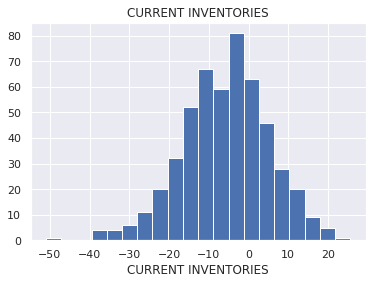

count   509.000
mean     33.634
std      20.010
min     -17.600
5%       -1.020
10%       7.680
20%      17.300
30%      23.200
40%      28.020
50%      32.800
60%      38.500
70%      43.000
80%      50.040
90%      61.900
95%      67.940
99%      78.764
max      83.900
Name: FUTURE ACTIVITY INDEX, dtype: float64


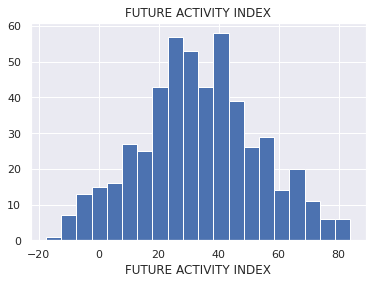

count   509.000
mean     35.893
std      17.465
min      -8.900
5%        6.260
10%      13.400
20%      21.720
30%      26.680
40%      31.240
50%      36.200
60%      40.000
70%      44.300
80%      50.200
90%      57.780
95%      66.700
99%      78.152
max      84.600
Name: FUTURE NEW ORDERS, dtype: float64


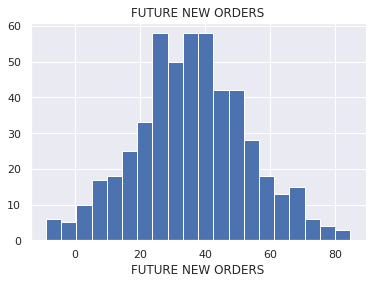

count   509.000
mean     -2.835
std      12.230
min     -41.400
5%      -21.420
10%     -17.600
20%     -12.740
30%      -9.100
40%      -6.500
50%      -3.600
60%      -0.500
70%       2.700
80%       6.640
90%      13.700
95%      19.260
99%      25.760
max      41.000
Name: FUTURE INVENTORIES, dtype: float64


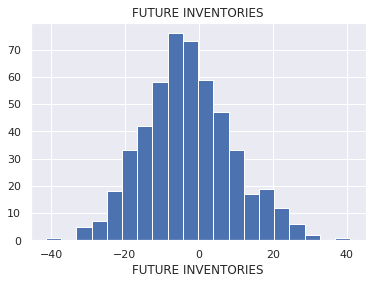

count       509.000
mean     389181.401
std      254231.324
min      178000.000
5%       227880.000
10%      264900.000
20%      303260.000
30%      320250.000
40%      336250.000
50%      351000.000
60%      371370.000
70%      398700.000
80%      424200.000
90%      486350.000
95%      588200.000
99%      916748.000
max     4663250.000
Name: initial claims monthly av, dtype: float64


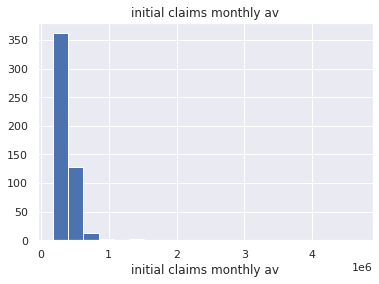

count   509.000
mean     77.713
std      38.795
min       9.320
5%       36.620
10%      38.688
20%      42.886
30%      47.386
40%      55.500
50%      67.310
60%      83.014
70%     104.452
80%     111.446
90%     126.032
95%     150.322
99%     204.616
max     205.190
Name: spx earning, dtype: float64


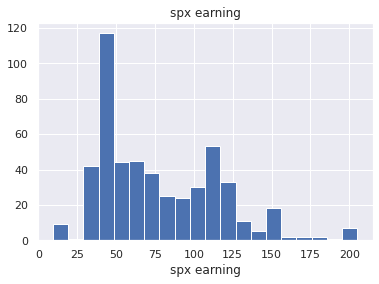

count   509.000
mean     75.549
std      21.003
min      40.647
5%       44.850
10%      47.242
20%      52.550
30%      55.251
40%      68.823
50%      81.870
60%      85.533
70%      90.816
80%      97.598
90%     101.830
95%     104.246
99%     106.096
max     106.762
Name: ind production, dtype: float64


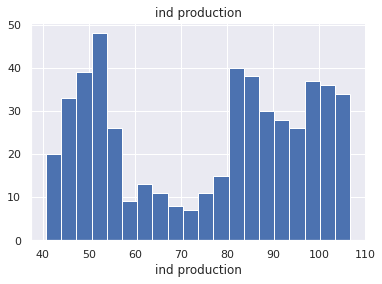

count   509.000
mean     65.053
std       1.644
min      60.200
5%       62.400
10%      62.800
20%      63.260
30%      63.900
40%      64.600
50%      65.700
60%      66.100
70%      66.300
80%      66.600
90%      66.900
95%      67.100
99%      67.200
max      67.300
Name: lab force parti, dtype: float64


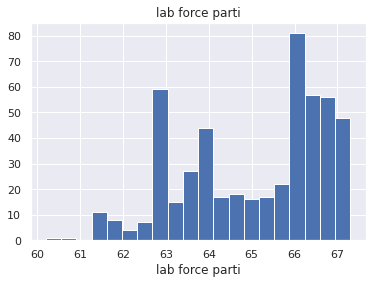

count   509.000
mean     77.352
std       4.222
min      60.814
5%       70.179
10%      72.277
20%      74.272
30%      75.391
40%      76.276
50%      77.797
60%      78.669
70%      79.688
80%      81.004
90%      82.718
95%      83.448
99%      84.529
max      85.617
Name: cap kulla, dtype: float64


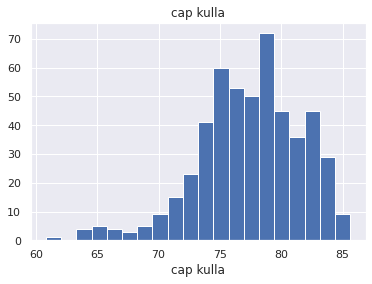

count   509.000
mean      8.084
std       3.262
min       3.160
5%        3.928
10%       4.526
20%       5.130
30%       6.126
40%       6.734
50%       7.650
60%       8.150
70%       9.092
80%      10.454
90%      13.464
95%      14.694
99%      16.818
max      17.180
Name: moodys baa credit yield, dtype: float64


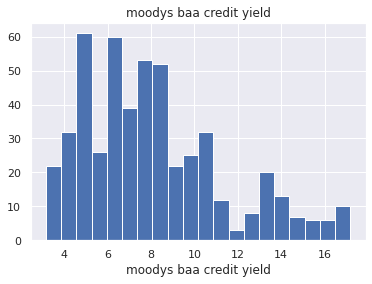

count      509.000
mean    123195.776
std      18230.025
min      88771.000
5%       90637.800
10%      93719.400
20%     105460.400
30%     109729.200
40%     121187.000
50%     130422.000
60%     131880.000
70%     134619.400
80%     138079.400
90%     145457.600
95%     149164.000
99%     151314.000
max     152504.000
Name: nfp, dtype: float64


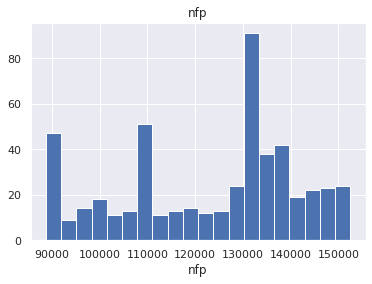

count   509.000
mean    147.923
std      40.949
min      85.200
5%       99.400
10%     100.740
20%     107.620
30%     118.400
40%     125.220
50%     131.500
60%     154.860
70%     182.660
80%     194.840
90%     203.120
95%     204.720
99%     243.131
max     264.666
Name: ppi, dtype: float64


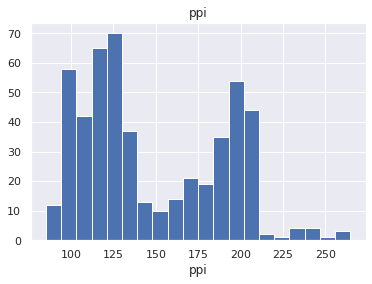

count   509.000
mean      2.872
std       5.647
min     -16.058
5%       -5.640
10%      -3.312
20%      -1.007
30%       0.492
40%       1.379
50%       2.309
60%       3.773
70%       4.564
80%       6.266
90%       9.202
95%      13.470
99%      20.537
max      22.686
Name: ppiyoy, dtype: float64


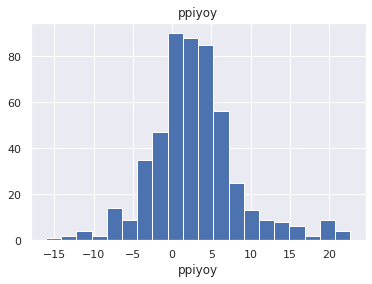

count   509.000
mean      0.236
std       0.964
min      -5.333
5%       -1.211
10%      -0.719
20%      -0.258
30%      -0.093
40%       0.087
50%       0.201
60%       0.361
70%       0.518
80%       0.808
90%       1.350
95%       1.805
99%       2.784
max       3.212
Name: ppimom, dtype: float64


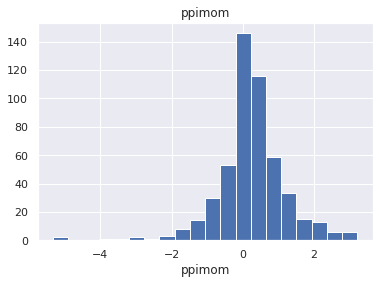

count    509.000
mean    1164.784
std      991.226
min      102.090
5%       131.036
10%      164.416
20%      288.660
30%      420.892
40%      743.996
50%     1059.780
60%     1217.496
70%     1365.878
80%     1791.878
90%     2647.674
95%     3124.704
99%     4505.927
max     4766.180
Name: spx, dtype: float64


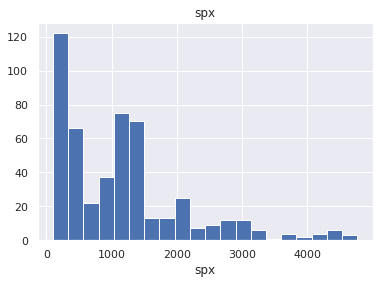

count   509.000
mean     10.516
std      16.008
min     -44.756
5%      -18.052
10%     -10.695
20%      -0.902
30%       4.976
40%       8.803
50%      11.990
60%      14.523
70%      17.989
80%      22.900
90%      29.025
95%      34.379
99%      46.485
max      53.715
Name: spxyoyreturn, dtype: float64


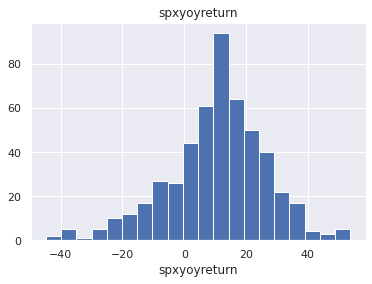

count   509.000
mean      0.807
std       4.354
min     -21.763
5%       -6.760
10%      -4.575
20%      -2.187
30%      -0.960
40%       0.270
50%       1.153
60%       1.906
70%       2.974
80%       3.962
90%       5.767
95%       7.380
99%      10.771
max      13.177
Name: spxmomreturn, dtype: float64


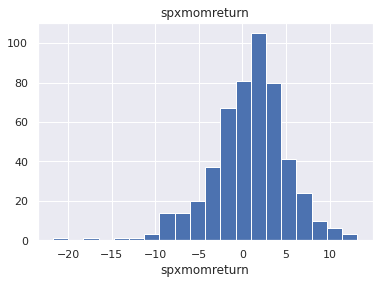

count   509.000
mean      2.488
std       7.554
min     -30.170
5%      -10.897
10%      -6.731
20%      -2.232
30%      -0.302
40%       1.428
50%       2.913
60%       4.622
70%       6.174
80%       7.962
90%      10.977
95%      13.611
99%      19.884
max      25.038
Name: spx 3mreturn, dtype: float64


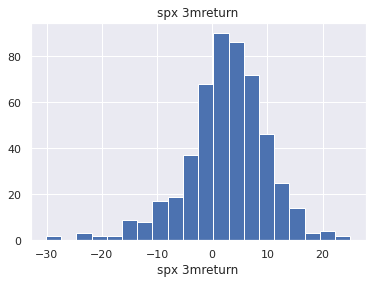

count   509.000
mean      5.074
std      10.864
min     -42.698
5%      -12.645
10%      -8.069
20%      -3.255
30%       1.399
40%       3.618
50%       5.338
60%       7.796
70%      10.152
80%      13.292
90%      18.350
95%      21.877
99%      29.275
max      38.844
Name: spx 6m return, dtype: float64


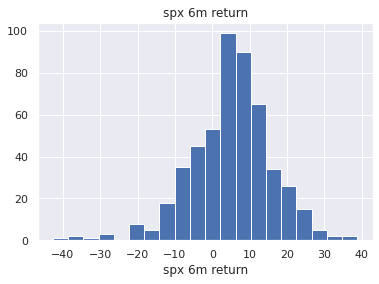

count   509.000
mean      6.200
std       1.771
min       3.500
5%        3.900
10%       4.200
20%       4.660
30%       5.100
40%       5.400
50%       5.800
60%       6.300
70%       7.060
80%       7.500
90%       9.000
95%       9.600
99%      10.400
max      14.700
Name: unemprate, dtype: float64


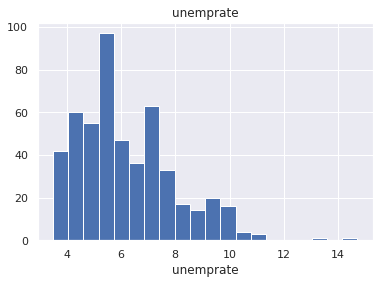

count   509.000
mean     81.163
std      18.757
min      47.071
5%       50.418
10%      53.983
20%      61.147
30%      64.131
40%      77.762
50%      89.274
60%      92.733
70%      96.923
80%      99.239
90%     101.660
95%     102.513
99%     103.981
max     105.597
Name: usindproduction, dtype: float64


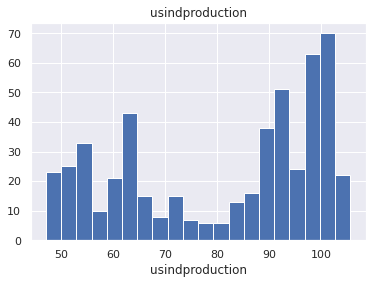

count   509.000
mean     -3.614
std       3.223
min     -18.580
5%       -9.787
10%      -7.895
20%      -4.829
30%      -4.335
40%      -3.667
50%      -3.124
60%      -2.714
70%      -2.340
80%      -1.725
90%       0.044
95%       1.149
99%       2.412
max       2.620
Name: us treasury federal budget deficit or surplus as a % of nominal GDP, dtype: float64


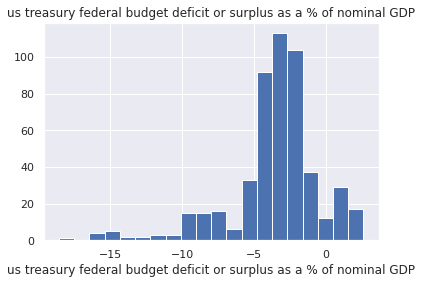

In [180]:
#Nümerik değişkenleri özetleme
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

#num_summary(df,"ppi",plot=True)      # 1 tanenin özeti
for col in num_cols:
    num_summary(df, col, plot=True)


In [181]:
## Bağımlı değişkenle sayısal değişken arasındaki bağlantı.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

    
# target_summary_with_num(df,"resesyonbagimlidegisken","cpi")          #1 tanesi

for col in num_cols:
    target_summary_with_num(df, "resesyonbagimlidegisken", col)



                         UOM-Consumerconfidence
resesyonbagimlidegisken                        
0                                        88.600
1                                        69.312


                         UOM-currenteconomicconditions
resesyonbagimlidegisken                               
0                                              100.226
1                                               79.757


                         UOM-consumerexpectations
resesyonbagimlidegisken                          
0                                          81.132
1                                          62.597


                         UOM-inflationexpectations
resesyonbagimlidegisken                           
0                                            3.210
1                                            4.498


                         stickycpi-yoy
resesyonbagimlidegisken               
0                                3.257
1                                6.066


                  

In [182]:
## Bağımlı değişkenle Kategorik değişken arasındaki bağlantı.

def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

#target_summary_with_cat(df,"resesyonbagimlidegisken","gdplabel")          #1 tanesi
    
    
for col in cat_cols:
    target_summary_with_cat(df, "resesyonbagimlidegisken", col)    

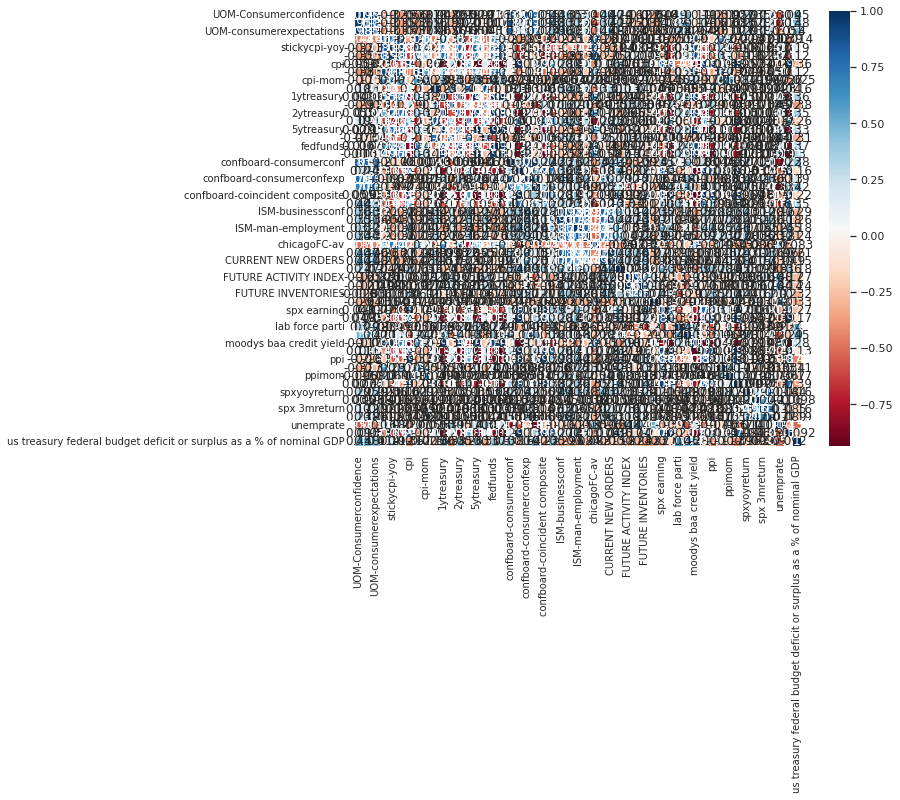

In [183]:
#Sayısal değişkenlerin arasındaki korelasyonu gösterir

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

    
correlation_matrix(df, num_cols)

# 2. Data Preprocessing & Feature Engineering
EKSİK DEĞERLERİ KONTROL ET VE DOLDUR - AYKIRI NÜMERİK DEĞERLERİ KONTROL ET VE AYKIRILARIN YERİNE EŞİK DEĞERLERİ KOY - FEATURE ENGINEERING İLE YENİ DEĞİŞKENLER ÜRET - ONE HOT ENCODING YAP
#YENİ ÜRETİLEN DEĞİŞKENLERİ CAT-NUM COLS'E EKLE( grab col names'i tekrar tanımlayarak da olur )

In [250]:
#Kategorik değişkenleri one hot encoder'dan geçiriyoruz.

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [251]:




#for i in num_cols:
#  df[i+"3m-MA"]=df[i].rolling(window =3).mean()
#  df[i+"6m-MA"]=df[i].rolling(window =6).mean()
#  df[i+"9m-MA"]=df[i].rolling(window =9).mean()
#  df[i+"12m-MA"]=df[i].rolling(window =12).mean()
    
    
#Degerden MAnın cıkarılması


#for i in num_cols:
#    df[i+"deger-MA"]=df[i]-df[i+"3m-MA"]
#    df[i+"deger-MA"]=df[i]-df[i+"6m-MA"]
#    df[i+"deger-MA"]=df[i]-df[i+"9m-MA"]
#    df[i+"deger-MA"]=df[i]-df[i+"12m-MA"]
    

    
    
# nominal degisimler

#for i in num_cols:
#    df[i+"1aylikdeg"]= (df[i]-df[i].shift(1)) #  aylık degisim
#    df[i+"3aylikdeg"]= (df[i]-df[i].shift(3)) #  aylık degisim                                                      
#    df[i+"6aylikdeg"]= (df[i]-df[i].shift(6)) #  aylık degisim
#    df[i+"9aylikdeg"]= (df[i]-df[i].shift(9)) #  aylık degisim
#    df[i+"12aylikdeg"]= (df[i]-df[i].shift(12)) #  aylık degisim
    

#yüzde degisimler
#for i in num_cols:
#    df[i+"1aylikyuzdedeg"]= (df[i]/df[i].shift(1)) -1
#    df[i+"3aylikyuzdedeg"]= (df[i]/df[i].shift(3)) -1
#    df[i+"6aylikyuzdedeg"]= (df[i]/df[i].shift(6)) -1
#    df[i+"9aylikyuzdedeg"]= (df[i]/df[i].shift(9)) -1
#    df[i+"12aylikyuzdedeg"]= (df[i]/df[i].shift(12)) -1
    
    
    
    
#df=df.drop(labels=range(0,12), axis=0)
#df=df.reset_index()
#df.drop("index",axis=1,inplace=True)

In [252]:
#One hot encoder'dan geçtikten sonra oluşan değişkenleri cat cols'a alsın diye tekrar grab col names'i çalıştırıyoruz         ve daha sonra bağımlı değişkeni cat cols'dan siliyoruz.
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)
cat_cols.remove("resesyonbagimlidegisken")

Observations: 509
Variables: 55
cat_cols: 1
num_cols: 54
cat_but_car: 0
num_but_cat: 1


Normalde ağaca dayalı modellerde nümerik değişkenleri standartlaştırmaya gerek yoktur
ancak bir pipeline yapacağımızda başka modellere de soracağımız için standartlaştırma gerekecek. O yüzden nümerik değişkenleri standartlaştırıyoruz.


In [135]:
#Yapmadım
#X_scaled = StandardScaler().fit_transform(df[num_cols])
#df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)


SON KONTROLLER 

In [253]:
df.head()
df.drop("date",axis=1,inplace=True)






# 3: MODEL KURMA -PIPELINE


In [254]:
train = df[:228]
test = df[228:]
cols = [col for col in df.columns if col not in ['date',"resesyonbagimlidegisken"]]

Y_train = train['resesyonbagimlidegisken']
X_train = train[cols]

Y_test = test['resesyonbagimlidegisken']
X_test = test[cols]

In [255]:
def base_models(X_train, Y_train, scoring="recall"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))  
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X_train, Y_train, cv=10, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [256]:
base_models(X_train, Y_train, scoring="recall")
#base_models(X_train, Y_train, scoring="precision")
base_models(X_train, Y_train, scoring="f1")


Base Models....
recall: 0.8667 (LR) 
recall: 0.5333 (KNN) 
recall: 0.5333 (SVC) 
recall: 0.9 (CART) 
recall: 0.8667 (RF) 
recall: 0.8667 (Adaboost) 


KeyboardInterrupt: 

In [71]:
######################################################

knn_params = {"n_neighbors": range(1,100)}

cart_params = {'max_depth': range(1,100),
               "min_samples_split": range(10, 100)}

rf_params = {"max_depth": [1,8, 15, None],
             "max_features": [5, 7,15, "auto",25],
             "min_samples_split": [5,50,100,200],
             "n_estimators": [50,100,200, 300,1000]}

xgboost_params = {"learning_rate": [0.3,0.1, 0.01,0.05,0.001],
                  "max_depth": [3,5, 8,10,20,50,100],
                  "n_estimators": [100, 200,1000,5000]}

lightgbm_params = {"learning_rate": [0.1, 0.01,0.05,0.001],
                   "n_estimators": [50,100, 200,1000]}



classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]



def hyperparameter_optimization(X_train, Y_train, cv=10, scoring="recall"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X_train, Y_train, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X_train, Y_train)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model,X_train, Y_train, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models





In [72]:
best_models = hyperparameter_optimization(X_train, Y_train)

Hyperparameter Optimization....
########## KNN ##########
recall (Before): 0.5333
recall (After): 0.5333
KNN best params: {'n_neighbors': 36}

########## CART ##########
recall (Before): 0.9
recall (After): 0.9
CART best params: {'max_depth': 80, 'min_samples_split': 16}

########## RF ##########
recall (Before): 0.9
recall (After): 0.7667
RF best params: {'max_depth': 1, 'max_features': 7, 'min_samples_split': 100, 'n_estimators': 50}

########## XGBoost ##########
recall (Before): 0.9
recall (After): 0.9
XGBoost best params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}

########## LightGBM ##########
recall (Before): 0.9
recall (After): 0.9
LightGBM best params: {'learning_rate': 0.1, 'n_estimators': 50}



# 3: HİPERPARAMETRE OPTİMİZASYONU


In [257]:
model = LGBMClassifier().fit(X_train,Y_train)
cv_results = cross_validate(model, X_train, Y_train, cv=10, scoring=["accuracy", "f1", "roc_auc","precision"])
params = {"learning_rate": [0.1],
                "n_estimators": [50]}

model_best_grid = GridSearchCV(model, params, cv=10, n_jobs=-1, verbose=True).fit(X_train, Y_train)
model_final = model.set_params(**model_best_grid.best_params_, random_state=17).fit(X_train, Y_train)
cv_results = cross_validate(model_final, X_train, Y_train, cv=10, scoring=["accuracy", "f1", "roc_auc","precision"])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [258]:
Y_pred = model_final.predict(X_test)

In [259]:
def plot_importance(model, features, num=len(X_test), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

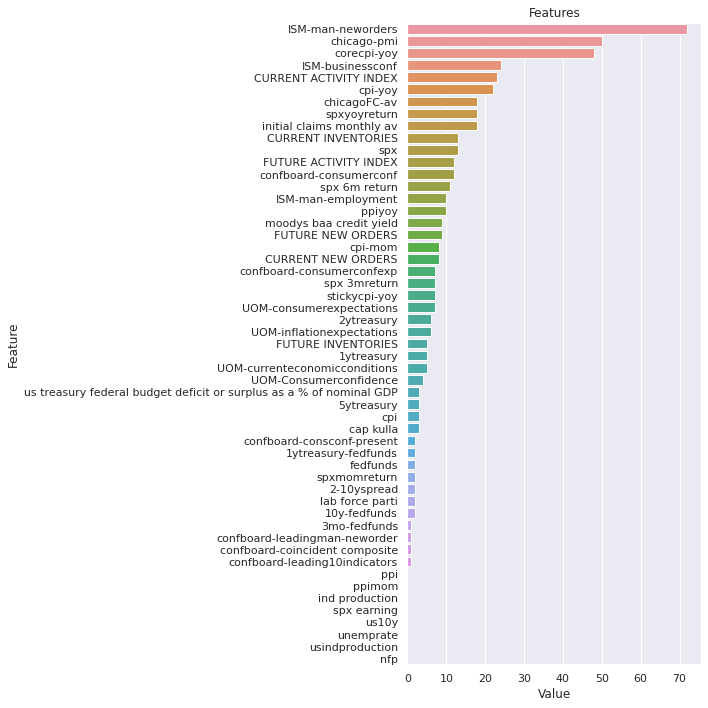

In [260]:
plot_importance(model_final, X_test)

In [261]:

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       1.00      0.29      0.44        28

    accuracy                           0.93       281
   macro avg       0.96      0.64      0.70       281
weighted avg       0.93      0.93      0.91       281



#Çok fazla değişken varsa Feature importance ile modelden bir şeyleri atma kodu


In [262]:
feature_imp = pd.DataFrame({'Value': model_final.feature_importances_, 'Feature': X_test.columns}).sort_values(by="Value")
feature_imp[feature_imp["Value"]<100]
drop_list = feature_imp["Feature"][0:20]
X_train.drop(drop_list,axis=1,inplace=True)              
X_test.drop(drop_list,axis=1,inplace=True)

In [263]:
model = LGBMClassifier().fit(X_train,Y_train)
cv_results = cross_validate(model, X_train, Y_train, cv=10, scoring=["accuracy", "f1", "roc_auc","precision"])
params = {"learning_rate": [0.1],
            "n_estimators": [50]}

model_best_grid = GridSearchCV(model, params, cv=10, n_jobs=-1, verbose=True).fit(X_train, Y_train)
model_final = model.set_params(**model_best_grid.best_params_, random_state=17).fit(X_train, Y_train)
cv_results = cross_validate(model_final, X_train, Y_train, cv=10, scoring=["accuracy", "f1", "roc_auc","precision"])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [264]:
Y_pred = model_final.predict(X_test)



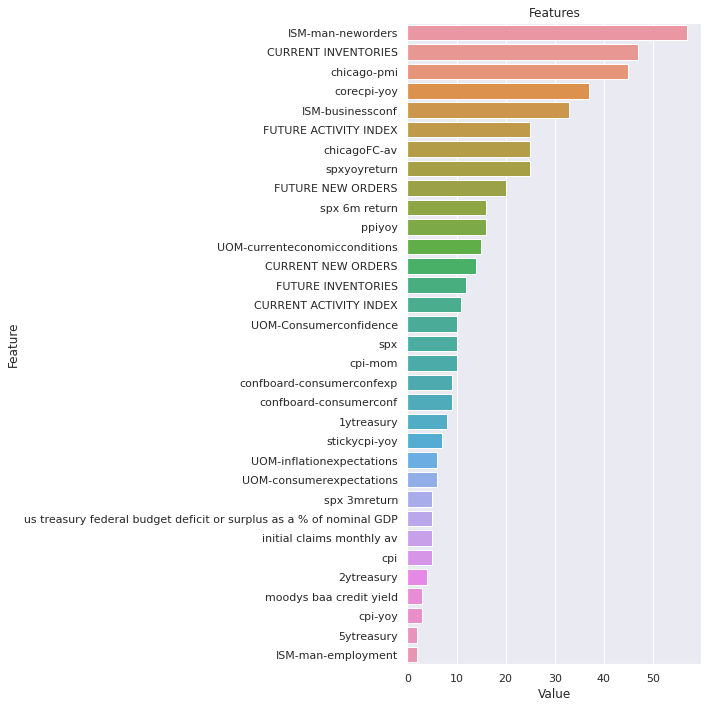

In [265]:
plot_importance(model_final, X_test)

In [266]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       1.00      0.29      0.44        28

    accuracy                           0.93       281
   macro avg       0.96      0.64      0.70       281
weighted avg       0.93      0.93      0.91       281



# 5. Stacking & Ensemble Learning- birden fazla modeli  bir arada kullanmaya dayanmaktadır.

In [267]:
def voting_classifier(best_models,X_train,Y_train):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('XGBoost', best_models["XGBoost"]),
                                              ('CART', best_models["CART"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X_train,Y_train)

    cv_results = cross_validate(voting_clf, X_train,Y_train, cv=10, scoring=["accuracy", "f1", "recall","precision"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"Precision: {cv_results['test_precision'].mean()}")
    print(f"Recall: {cv_results['test_recall'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X_train, Y_train)


Voting Classifier...
Accuracy: 0.9217391304347826
F1Score: 0.8372932330827068
Precision: 0.84375
Recall: 0.9


In [268]:
Y_pred = voting_clf.predict(X_test)

In [269]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       253
           1       0.64      0.32      0.43        28

    accuracy                           0.91       281
   macro avg       0.79      0.65      0.69       281
weighted avg       0.90      0.91      0.90       281



In [271]:

#Probability'i getirme. ve tahmini görme.


In [272]:

voting_clf.predict_proba(X_test)
predicted_proba=voting_clf.predict_proba(X_test)


In [273]:
dff = pd.DataFrame(predicted_proba)
dff

,0,1
0,0.999,0.001
1,0.999,0.001
2,0.999,0.001
3,0.999,0.001
4,0.999,0.001
5,0.999,0.001
6,0.999,0.001
7,0.999,0.001
8,0.999,0.001
9,0.999,0.001


In [274]:
dff.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [275]:
X_test["recession_proba"]=dff[1]

In [276]:
Y_test=Y_test.reset_index()

In [277]:
dff=pd.DataFrame(Y_test)

In [278]:
X_test["recessionREAL"]=dff["resesyonbagimlidegisken"]

In [279]:
X_test[["recession_proba","recessionREAL"]]

,recession_proba,recessionREAL
0,0.001,0
1,0.001,0
2,0.001,0
3,0.001,0
4,0.001,0
5,0.001,0
6,0.001,0
7,0.001,0
8,0.001,0
9,0.001,0


In [88]:
#Deneme Classification threshholdu düşürme # RF FİNAL İLE YAPTIK ÇÜNKÜ VOTING CLF DEĞERİ DÜŞÜK ÇIKTI

In [280]:
X_test.drop("index",axis=1,inplace=True)
X_test.drop("recession_proba",axis=1,inplace=True)
X_test.drop("recessionREAL",axis=1,inplace=True)
#yukarıda gereksiz olarak eklediğim şeyleri sildim
Y_test.drop("index",axis=1,inplace=True)

In [287]:
Y_pred = (model_final.predict_proba(X_test)[:,1] >= 0.25).astype(bool) # set threshold as 0.3


In [288]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       253
           1       1.00      0.32      0.49        28

    accuracy                           0.93       281
   macro avg       0.97      0.66      0.73       281
weighted avg       0.94      0.93      0.92       281



In [289]:
#Probability'i getirme. ve tahmini görme.

model_final.predict_proba(X_test)
predicted_proba=model_final.predict_proba(X_test)

dff = pd.DataFrame(predicted_proba)
dff

dff.reset_index(inplace=True)
X_test.reset_index(inplace=True)

X_test["recession_proba"]=dff[1]

Y_test=Y_test.reset_index()

dff=pd.DataFrame(Y_test)

X_test["recessionREAL"]=dff["resesyonbagimlidegisken"]

X_test[["recession_proba","recessionREAL"]]


,recession_proba,recessionREAL
0,0.001,0
1,0.001,0
2,0.001,0
3,0.001,0
4,0.001,0
5,0.001,0
6,0.001,0
7,0.001,0
8,0.001,0
9,0.001,0
